# Boosting

Ruixuan Dong

---

This tutorial is based on the context of Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction (2nd ed.). Stanford, CA: Stanford University.

---

## Table of Contents
 - [Adaboost.M1](#1)
 - [Boosting as a forward stagewise additive model](#2)
 - [Exponential loss](#3)
 - [Boosting trees](#4)
 - [Gradient boosting](#5)
 - [Tuning boosted trees](#6)
 - [Regularization](#7)
 - [Relative variable importance](#8)
 - [Simulated Dataset](#9)

<a name='1'></a>

### 1 Adaboost.M1

This is a procedure originally designed for classification problems, but can be extended to regression problems in a straightforward way. The idea of boosting is to combine many "weak" classifiers in order to construct a powerful "committee". In this way, boosting is like bagging (and consequently, random forests), but we will see that in fact, boosting is fundamentally different.

To make matters concrete, let us return to the setting where $Y$ is a binary random variable which we encode by $Y \in \{-1, 1\}$. Consider a set of predictors $X$ and a prediction function $G(X)$ taking values in $\{-1, 1\}$. The error rate on a training sample $\{(y_i,x_i)\}_{i=1}^n$ is given by
$$
\frac{1}{n} \sum_{i=1}^{n} \mathbf{1}\{y_i \neq G(x_i)\},
$$
and the expected error rate on future predictions is the expectation of $\mathbf{1}\{Y \neq G(X)\}$ with respect to the joint distribution of $X$ and $Y$.

When we say we are combining weak classifiers, we mean classifiers which perform only slightly better than random guessing. In boosting, we repeatedly refit the classifier to a weighted version of the dataset. Then, we take a weighted average of these classifiers, where the weights are a function of the prediction accuracy. For example, if we let $G_m(x)$, $m = 1, \ldots, M$ denote a sequence of weak classifiers fit to different versions of the sample data. Our final estimator would be a weighted majority vote estimator:
$$
G^{(M)}(X) = \text{sign} \left( \sum_{m=1}^M \alpha_m G_m(x) \right),
$$
where the weights $\alpha_1, \ldots, \alpha_M$ are computed in the process of constructing the $G_m$. Naturally, these weights can be interpreted in terms of the relative contribution of each classifier to the overall classifier. Intuitively, if $G_l$ has high classification accuracy, then $\alpha_l$ should be large relative to the other $\alpha_m$.

Why boosting works well is a function of how the classifiers $G_m$ are constructed. As mentioned, each $G_m$ is computed based on a weighted version of the dataset. To compute $G_1$, we start with weights $\frac{1}{n}$ assigned to each sample point. Then, we record misclassification accuracy and compute a new set of weights: upweighting points which are misclassified and downweighting those correctly classified. With this new weighted version of the dataset, we then fit $G_2$. This process is repeated until $M$ weak learners are obtained. A schematic taken from Hastie et al. (2009) can be found in Figure 1.

<img src="figure1.png" alt="Figure 1" width="400" height="400">
<p style="text-align:left;">Figure 1: Schematic of the boosting procedure from Hastie et al. (2015).</p>

Now, let us formally state a boosting algorithm: this particular version is known as AdaBoost.M1.

<br>

<hr style="height:1px;border-width:0;color:black;background-color:black">

**Algorithm 1: AdaBoost.M1**

1. Initialize the observation weights $w_i = \frac{1}{n}$ for $i = 1, \ldots, n$.

2. For $m = 1, \ldots, M$:

    a. Fit classifier $G_m$ to the training data with weights $\{w_i\}_{i=1}^n$.
    
    b. Compute the classifier $G_m$'s weighted training error $\varepsilon_m = \sum_{i=1}^{n} w_i \mathbf{1}\{y_i \neq G_m(x_i)\}$.
    
    c. Compute $\alpha_m = \log\left(\frac{1-\varepsilon_m}{\varepsilon_m}\right)$.
    
    d. Update weights $w_i \leftarrow w_i \exp[\alpha_m \mathbf{1}\{y_i \neq G_m(x_i)\}]$.
    
3. Set $G(x) = \text{sign}\left\{\sum_{m=1}^{M} \alpha_m G_m(x)\right\}$.


<hr style="height:1px;border-width:0;color:black;background-color:black">

<br>


Boosting can improve the prediction accuracy of a "weak" classifier in somewhat surprising ways. Taking an example from Hastie et al. (2009), suppose we had predictors $X \sim N_{10}(0, I_{10})$ and $Y$ deterministically defined by

$$
Y = \left\{
\begin{array}{ll}
1 & \text{if} \sum_{j=1}^{10} X_j^2 > \chi^2_{10}(0.5) \\
-1 & \text{otherwise}
\end{array}
\right.
$$

Then, with a training set of size $n = 2000$ and 10000 test cases, the AdaBoost.M1 algorithm is run using a "stump" – the cleverly named version of a regression tree with only a single split (i.e., a two-region partition). When applied naively to the training data, the testing error rate is nearly as bad as random guessing (45.8%), which should not be surprising. However, as the number of boosting iterations increases, the testing error starts to approach 5.8%. This can be compared to a full 244-node regression tree, which has a testing error around 25%. See Figure

<img src="figure2.png" alt="Figure 2" width="400" height="400">
<p style="text-align:left;">Figure 2: Stump boosting example testing error from Hastie et al. (2009).
</p>

While somewhat intuitive – we are simply adjusting weights to put more importance on misclassified points – we have yet to touch upon the mechanism through which boosting works. Going forward we will:

- Show that AdaBoost fits an additive model to a “base” learner so as to minimize an exponential loss function.
- Show that the population minimizer of the exponential loss is the log-odds of the class probabilities.
- Discuss alternative loss functions, and gradient boosting – a method for boosting trees under any loss function.




<a name='2'></a>
### 2 Boosting as a forward stagewise additive model

Examining the form of the boosting estimator,
$$
G(x) = \text{sign}\left\{\sum_{m=1}^M \alpha_m G_m(x)\right\},
$$
it is not difficult to convince yourself that boosting is a method for fitting an additive expansion in a set of very elementary basis functions. Of course, here, the basis functions are individual classifiers $G_m$. Recall that basis expansions take the form
$$
f(x) = \sum_{m=1}^M \beta_m b(x; \gamma_m)
$$
where $\beta_m$, $m = 1, \ldots, M$ are the basis expansion coefficients and $b(x; \gamma_m) \in \mathbb{R}$ are usually simple functions of the $p$-dimensional input variable $x$ (characterized by parameter set $\gamma$). Some of the methods we are yet to discuss in this class can be characterized in this way.

- For example, in single-hidden-layer neural networks, we take $b(x:\gamma)=\sigma(\gamma_0 +\gamma_1^\prime x)$ where $\sigma(t) = \{1 + \exp(-t)\}^{-1}$ is the "sigmoid" function, and $\gamma$ is a set of regression coefficients.
- In a more familiar example, trees, $\gamma$ represents the split variables and split points at the internal nodes, and the predictions are the terminal nodes.

One helpful way to characterize boosting relates this method to forward stepwise modeling. To understand this connection, recall forward stepwise regression (which we mentioned only in passing): given a continuous response $y \in \mathbb{R}^n$ and predictors $X_1, \ldots, X_p \in \mathbb{R}^n$, we

1. Choose the predictor $X_j$ with smallest squared error loss $\sum_{i=1}^n(y_i - \hat{\beta}_j X_{i,j})^2$.
2. Choose the next predictor with smallest squared error loss $\sum_{i=1}^n(r_i - \hat{\beta}_k X_{i,k})^2$ where $r_i = y_i - \hat{\beta}_j X_{i,j}$.
3. Repeat Step 2.

Returning to the characterization of boosting as an additive model, we can see that these models are fit by minimizing a loss function averaged over all the sample data, e.g.,

$$
\min_{\{\beta_m, \gamma_m\}_{m=1}^M} \sum_{i=1}^n L\left(y_i, \sum_{m=1}^M \beta_m b(x_i; \gamma_m)\right). \tag{1}
$$

This is often computationally expensive to solve, but if we apply the forward stagewise modeling approach, we can convince ourselves that as long as we can compute

$$
\min_{\beta, \gamma} \sum_{i=1}^n L(y_i, \beta b(x_i; \gamma)),
$$
we can solve (1).


<br>

<hr style="height:1px;border-width:0;color:black;background-color:black">

**Algorithm 3**: Forward Stagewise Additive Modeling

1. Initialize $f_0(x) = 0$.

2. For $m = 1, \ldots, M$:

    a. Compute
$$
       (\beta_m, \gamma_m) = \arg\min_{\beta, \gamma} \sum_{i=1}^n L\{y_i, f_{m-1}(x_i) + \beta b(x_i; \gamma)\}.
$$
       
    b. Set $f_m(x) = f_{m-1}(x) + \beta_m b(x; \gamma_m)$.


<hr style="height:1px;border-width:0;color:black;background-color:black">

<br>


For example, were $L$ squared error loss, we see that the objective function in 2(a) can be written

$$
\sum_{i=1}^n L(y_i, f_{m-1}(x_i) + \beta b(x_i; \gamma)) = \sum_{i=1}^n \{y_i - f_{m-1}(x_i) - \beta b(x_i; \gamma)\}^2
= \sum_{i=1}^n \{r_i(m) - \beta b(x_i; \gamma)\}^2
$$

where $r_i(m) = y_i - f_{m-1}(x_i)$ for $i = 1, \ldots, n$.

While this idea is helpful in terms of gaining intuition about boosting, it is still not clear what loss function $L$ AdaBoost.M1 is minimizing at each step. It turns out that AdaBoost.M1 (Algorithm 1) is equivalent to forward stagewise additive modeling (Algorithm 2) using the loss function

$$
L\{y, f(x)\} = \exp\{-yf(x)\},
$$

which we will call the exponential loss function. We will discuss why this loss function is appropriate momentarily. For now, let us characterize the update from Step 2(a). Using the exponential loss, we see that 2(a) is

$$
(\beta_m, G_m) = \arg\min_{\beta, G} \sum_{i=1}^n \exp[-y_i\{f_{m-1}(x_i) + \beta G(x_i)\}].
$$


Of course, we can write this problem as

$$
(\beta_m, G_m) = \arg\min_{\beta, G} \sum w^{(m)}\exp\{-y_i\beta G(x_i)\}, \tag{2}
$$

where weights will change at every iteration.

To derive the solution to (2), notice that for any value of $\beta$ (fixed),

$$
G_m = \arg\min_G \sum w^{(m)} \mathbf{1}\{y_i \neq G(x_i)\},
$$

where $w^{(m)} = \exp\{-y_i f_{m-1}(x_i)\}$. Since each $w^{(m)}$ does not depend on $\beta$ or $G$, these can be regarded as weights for each observation. The minimizer is the classifier that minimizes the weighted error rate in classifying $y$.

We can rewrite the criterion on

$$
e^{-\beta} \sum_{y_i = G(x_i)} w^{(m)} + e^{\beta} \sum_{y_i \neq G(x_i)} w^{(m)}
$$

as

$$
(e^\beta - e^{-\beta})\sum w^{(m)} \mathbf{1}\{y_i \neq G(x_i)\} + e^{-\beta} \sum w^{(m)}.
$$

Hence, with this $G_m$, we plug this back into (2) to solve with respect to $\beta$. It follows that

$$
\beta_m = \frac{1}{2} \log \left(\frac{1 - \varepsilon_m}{\varepsilon_m}\right),
$$

where

$$
\varepsilon_m = \frac{\sum w^{(m)} \mathbf{1}\{y_i \neq G_m(x_i)\}}{\sum w^{(m)}}.
$$

Then, Step 2(b) of Algorithm 2 becomes

$$
f_m(x) = f_{m-1}(x) + \beta_m G_m(x),
$$

so that the weights for the next iteration become

$$
w^{(m+1)} = w^{(m)} \cdot \exp\{-\beta_m y_i G_m(x_i)\}.
$$

Based on these derivations, we can conclude that the AdaBoost.M1 algorithm is approximately minimizing the exponential loss function by fitting an additive model in a forward stagewise fashion.



<a name='3'></a>
### 3 Exponential loss

Notably, the AdaBoost.M1 algorithm was not originally proposed with the exponential loss in mind. In fact, it was years after AdaBoost had been introduced that the connection between this procedure and the exponential loss was identified. However, this interpretation of the AdaBoost.M1 algorithm allows us to gain more insights and reveals ways this procedure can be generalized and improved.

The exponential loss is attractive for this procedure particularly because it allows for simple, closed-form updates of the weights. But we must ask: what is the justification for minimizing the exponential loss? Clearly, it does not correspond to a particular likelihood, nor does it minimize misclassification accuracy on the training set (at least, in an explicit way). To address this question, we first consider the population level version of the exponential loss. Specifically, let

$$
f^*(x) = \arg\min_{f(x)} \mathbb{E}_{Y|X=x}[\exp\{-Yf(x)\}] = \frac{1}{2} \log \frac{P(Y = 1 | X = x)}{P(Y = -1 | X = x)},
$$

or equivalently,

$$
P(Y = 1 | X = x) = \frac{\exp\{f^*(x)\}}{\exp\{-f^*(x)\} + \exp\{f^*(x)\}} = \frac{1}{1 + \exp\{-2f^*(x)\}}.
$$

Hence, we can think of the additive expansion produced by the AdaBoost.M1 procedure as estimating one-half times the log-odds of $P(Y = 1 | X = x)$. This further justifies using the sign of the additive function as a classification rule.

Let us compare this to the negative log-likelihood for a Bernoulli random variable. Let $p(x) = P(Y = 1 | X = x)$ and define $\widetilde{Y} = (Y + 1)/2 \in \{0, 1\}$. Then, we can write the negative log-likelihood in terms of $p(x)$:

$$
-L(Y, p(x)) = \log[1 + \exp\{-2Yf(x)\}].
$$

We know that the population log-likelihood is maximized at the true probabilities: $p(x)$. Hence, we see that because the minimizer of $[1 + \exp\{-2f^*(x)\}]^{-1}$ is also the minimizer of $\log[1 + \exp\{-2Yf(x)\}]$, we see that at the population level, the exponential loss would give the same estimator as the negative log-likelihood. Of course, the exponential loss is not a log-likelihood and should not be interpreted as such.


<a name='4'></a>
### 4 Boosting trees

Recall from our discussion of regression trees that we can express a tree as

$$
T(x; \Theta) = \sum_{j=1}^J \gamma_j \mathbf{1}(x \in R_j)
$$

for regions $R_1, \ldots, R_J$, which are defined by parameter set $\Theta = \{\gamma_j, R_j\}_{j=1}^J$. We estimate these parameters using

$$
\hat{\Theta} = \arg\min_{\Theta} \sum_{i=1}^n L(y_i, \gamma_j).
$$

Of course, we saw that this was a fundamentally challenging problem for arbitrary $L$, so we relied on a greedy approximation using recursive binary partitioning. Let $T(x, \Theta_m)$ denote a tree based on parameters $\Theta_m$ estimated via recursive binary partitioning.

Then, we can express a boosted tree model as a sum of trees

$$
f_M(x) = \sum_{m=1}^M T(x, \Theta_m)
$$

where each term is estimated in a sequential, stagewise manner. At each step in the forward stagewise procedure, one solves

$$
\hat{\Theta}_m = \arg\min_{\Theta} \sum_{i=1}^n L(y_i, f_{m-1}(x_i) + T(x_i, \Theta)) \tag{3}
$$

for the region set $\{R_{jm}\}_{j=1}^M$ and constants $\{\gamma_{jm}\}_{j=1}^M$ defined by $\Theta$, given model $f_{m-1}(x)$. Given regions $R_{jm}$, finding the optimal constants is straightforward: we solve a problem of the form

$$
\hat{\gamma}_{jm} = \arg\min_{\gamma_{jm}} \sum L(y_i, f_{m-1}(x_i) + \gamma_{jm}).
$$

Computing the regions $R_{jm}$ is more difficult than it is for a single tree, but in a few special cases it is rather simple. For squared error loss, finding the regions and corresponding constants is no more difficult than for a single tree. It is simply a single tree fit to the residuals $y_i - f_{m-1}(x_i)$ for $i = 1, \ldots, n$.

For two-class classification and exponential loss, this stagewise approach yields exactly the AdaBoost procedure. Specifically, if the trees are restricted to be scaled classification trees (meaning $\gamma_{jm} \in \{-1, 1\}$), then, based on our discussion in Section 3.2, this is simply the tree that minimizes the weighted error rate where the weights are $w^{(m)} = \exp\{-y_i f_{m-1}(x_i)\}$. When $\gamma_{jm}$ is unrestricted, (3) still simplifies to a weighted exponential criterion for estimating a tree, which can be approximated using a recursive partitioning algorithm. Under exponential loss, it can be shown that

$$
\hat{\gamma}_{jm} = \frac{1}{2} \log \frac{\sum w^{(m)} \mathbf{1}(y_i = 1)}{\sum w^{(m)} \mathbf{1}(y_i = -1)}
$$

where

$$
\hat{\Theta}_m = \arg\min_{\Theta} \sum w^{(m)} \exp\{-y_i T(x_i, \Theta)\}.
$$

Computing unrestricted trees is computationally intensive. For this reason, we might prefer simpler approximations based on, say, weighted least squares. In the following subsection, we will discuss an approach for approximating (3) under general loss functions.


<a name='5'></a>
### 5 Gradient boosting

In this section, we focus on minimizing criteria of the form

$$
L(f) = \sum_{i=1}^n L\{y_i, f(x_i)\},
$$

where $f$ is restricted to be the sum of trees. Ignoring this constraint for a moment, we can see that the minimization of $L(f)$ can be viewed as the optimization problem

$$
\hat{f} = \arg\min_f L(f)
$$

where $f \in \mathbb{R}^n$ are the values of the approximating function $f(x_i)$ at each of the $n$ sample points:

$$
f = \{f(x_1), f(x_2), \ldots, f(x_n)\}'.
$$

One way to obtain $\hat{f}$ is to solve the optimization as a sum of component vectors

$$
f_M = \sum_{m=0}^M h_m, \quad h_m \in \mathbb{R}^n
$$

where $h_0$ denotes an initial guess, and each $f_m$ depends on $f_{m-1}$, the sum of previously induced updates. The question becomes how to compute each “increment” vector $h_m$.

One such approach is steepest descent. Steepest descent sets $h_m = -\rho_m g_m$ where $g_m$ is the gradient of $L(f)$ evaluated at $f = f_{m-1}$, and $\rho_m$ is a scalar. The components of the gradient $g_m$ are

$$
g_{im} = \left.\frac{dL(y_i, f(x_i))}{df(x_i)}\right|_{f(x_i)=f_{m-1}(x_i)},
$$

and the step length $\rho_m$ is defined as

$$
\arg\min_\rho L(f_{m-1} - \rho g_m).
$$

Hence, we obtain the approximate minimizer using

$$
f_m = f_{m-1} - \rho_m g_m.
$$

This procedure can be compared to the forward stagewise boosting discussed previously. At each step of the forward stagewise boosting algorithm, we fit a tree that minimizes the loss given the current model $f_{m-1}$. Hence, we can think of those trees as analogous to the negative gradient above in gradient boosting. The main difference is that in the forward stagewise approach, the predictions' components are constrained to be coming from a tree whereas in gradient boosting, the negative gradient is the unconstrained maximal descent direction. However, there is a disconnect we need to resolve. Ultimately, we wanted to solve (3) (i.e., obtain a new tree conditional on $f_{m-1}$). While the negative gradient gives us the direction of steepest descent, it does not yield a solution to (3). A resolution is as follows: we let the negative gradient induce a tree whose predictions are as close as possible to the negative gradient at each step. Specifically, we solve (3) using

$$
\tilde{\Theta}_m = \arg\min_\Theta \sum \left\{-g_{im} - T(x_i, \Theta)\right\}^2,
$$

which can be computed very efficiently. Although the solution regions to the above are not exactly the same as those from (3), they are generally similar. Then, with the regions, the functions in each region are obtained by the expression for $\hat{\gamma}_{jm}$ above. We summarize the gradient tree boosting algorithm for regression below.

<br>

<hr style="height:1px;border-width:0;color:black;background-color:black">

**Algorithm 4**: Gradient Tree Boosting Algorithm

1. Initialize $f_0(x) = \arg\min_{\gamma} \sum_{i=1}^n L(y_i, \gamma)$.

2. For $m = 1, \ldots, M$:

    a. For $i = 1, \ldots, n$ compute
$$
       r_{im} = \left.\frac{dL(y_i, f(x_i))}{df(x_i)}\right|_{f=f_{m-1}}
$$

    b. Fit a regression tree to the targets $-r_{im}$. Let the terminal nodes of this tree be denoted $R_{jm}$ for $j = 1, \ldots, J_m$.
    
    c. For $j = 1, \ldots, J_m$, compute $\hat{\gamma}_{jm}$ as the solution to the problem
$$
       \hat{\gamma}_{jm} = \arg\min_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i) + \gamma).
$$

    d. Update
$$
       f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m} \hat{\gamma}_{jm} \mathbf{1}(x \in R_{jm}).
$$

3. Output $f(x) = f_M(x)$.



<br>

<hr style="height:1px;border-width:0;color:black;background-color:black">



<a name='6'></a>
### 6 Tuning boosted trees

To implement boosting trees (or gradient boosting trees), one needs first to determine the size of the trees. Before, we argued that growing a large tree and pruning was the best strategy for estimating a single tree, but there, the context was different. This was the one and only tree to be used for prediction. In boosting, we are combining many trees, so overgrowing/pruning strategies are ill-advised. What is commonly done in practice is to simply set each tree to be of size $J$, where $J$ is treated as a model parameter to be tuned.

In addition, one also needs to choose the number of boosting iterations $M$. Each iteration will further decrease the training risk $L(f_M)$, so that as we let $M \rightarrow \infty$, the training risk will tend towards zero. As we have seen in this course, this too is ill-advised as the fitted model will not generalize well to new data. Thus, we can think of there being some optimal number, $M^*$, of boosting iterations which minimize the risk on new samples. One strategy to choose $M$ is to use a validation set on which we measure prediction risk. We would then select the value of $M$ which minimizes this risk on the validation set. This can be thought of as an “early-stopping rule” since we are not allowing $L$ to be minimized on the training data by terminating our algorithm early.


<a name='7'></a>
### 7 Regularization

Early stopping is not the only approach for mitigating overfitting as $M$ becomes large. As with ridge regression, and as we may discuss later in the course, neural networks, shrinkage techniques can also be applied. The simplest approach for shrinkage in the context of boosted trees is to scale the contribution of each tree by a factor of $\nu \in (0, 1)$ when it is added to the current approximation. That is, we would replace the update

$$
f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m} \gamma_{jm} \mathbf{1}(x \in R_{jm})
$$

with

$$
f_m(x) = f_{m-1}(x) + \nu \sum_{j=1}^{J_m} \gamma_{jm} \mathbf{1}(x \in R_{jm}).
$$

The parameter $\nu$ can be thought of as the learning rate of the boosting procedure. Smaller values of $\nu$ lead to more shrinkage, and thus, result in a larger training risk for the same number of iterations $M$. In this sense, it is the combination of $\nu$ and $M$ that control the prediction risk on the training data.

Empirically, it has been found that values of $\nu$ close to zero tend to perform better on out-of-sample prediction, but do require larger values of $M$. In fact, the best strategy appears to be setting $\nu$ to be quite close to zero (say, $\nu < 0.1$) and choose $M$ by early stopping. This often provides large improvements in prediction accuracy and probability estimation. The gains are less substantial in terms of classification accuracy, but apparent nonetheless.

Another approach for regularization in boosting trees uses subsampling. In stochastic gradient boosting, at each iteration we fit the new tree using a subsample of the training observations. Typically, we select a subsample consisting of half of the training samples, although if $n$ is large, a smaller proportion can be used.

Subsampling has two benefits. First, it reduces computing time, which is especially important when imposing the shrinking described above (which will inherently require larger $M$). Second, it often produces a more accurate model.



<img src="figure3.png" alt="Figure 3" width="400" height="400">

<a name='8'></a>
### 8 Relative variable importance


Like in random forests, it can be helpful to construct a metric for variable importance in boosted trees. For a single decision tree $T$, Breiman et al. (1984) proposed

$$
I_l^2(T) = \sum_{t=1}^{J-1} \hat{\kappa}_t^2 \mathbf{1}\{v(t) = l\}
$$

as a measure of importance for the variable $X_l$. The summation is taken over $J - 1$ internal (non-terminal) nodes of the tree. At each such node $t$, recall that one of the variables, say $v(t)$, was split into two regions at some point. This variable and split point were chosen to maximize the improvement, $\hat{\kappa}_t^2$, in square error risk over the model which fits a constant over the entire region. Thus, the variable importance measure defined above is the sum of all such squared improvements over all nodes for which the variable $X_l$ was chosen as the splitting variable.

To generalize this idea to boosted trees (or random forests) is straightforward: we simply average the measure above over the trees. Specifically, define

$$
I_l^2 = \frac{1}{M} \sum_{m=1}^M I_l^2(T_m).
$$

For reasons discussed in Hastie et al. (2009), this metric is somewhat robust to high correlations in the predictors. It is important to point out that both of the measures introduced here are squared relative importance: the `randomForest` package (and others) report the square root of these quantities. Since these metrics are all relative, it is common to set the largest equal to 100 and rescale all others accordingly.

For classification, a similar metric can be used. Supposing there are $K$ categories, $K$ separate models $f_k(x)$ are induced, each consisting of the sum of trees

$$
f_k(x) = \sum_{m=1}^M T_{km}(x).
$$

Then, the squared importance of the $l$th variable for separating the $k$th category from all others is given by

$$
I_{lk}^2 = \frac{1}{M} \sum_{m=1}^M I_{lk}^2(T_{km}),
$$

where $I_{lk}^2(T_{km})$ is the squared importance measure for the $l$th variable in the $k$th model tree $T_{km}$.

The overall importance of $X_l$ is then taken to be

$$
I_l^2 = \frac{1}{K}\sum_{k=1}^K I_{lk}^2.
$$


<a name='9'></a>
### 9 Simulated Dataset

In this part, we use the dataset generated by Synthetic SCG data generator https://github.com/wsonguga/DataDemo. In the data file, each row includes sensor data (10 seconds * 100Hz) + HeartRate + RespiratoryRate + SystolicBloodPressure + DiastolicBloodPressure.

Now we would like to give a introduction about the synthetic SCG dataset we generated. 

Based on Synthetic SCG data generator, we generated an artificial (synthetic) scg signal of a given duration (10 seconds, i.e. duration=10) and sampling rate (100Hz, i.e. sampling rate=100) using a model based on Daubechies wavelets to roughly approximate cardiac cycles.

Besides, we set 
 - heart rate to be randomly chosen from the intgers range from 50 to 150, with the desired heart rate standard deviation (beats per minute) equal to 1.
 - respiratory rate to be randomly chosen from the intgers range from 10 to 30
 - diastolic blood pressure to be randomly chosen from the intgers range from 60 to 99
 - systolic blood pressure to be randomly chosen from the intgers range from 100 to 160

The sample size of the current dataset is 6,000 in total.


**Problem Statement:** The generated dataset containing: 
- a dataset set ("lower.csv") of 3,000 samples labeled as lower (100<=systolic blood pressure<140) 
- a dataset set ("higher.csv") of 3,000 samples labeled as higher (140<=systolic blood pressure<=160) 
- each sample is of shape (1, 1003) where 1003 is for the 1000-d signal and heart rate, respiratory rate and diastolic blood pressure

In this part, we will build a simple kNN classifier that can correctly classify samples as lower or higher (SBP).

Let's get more familiar with the dataset. Load the data by running the following code.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [6]:
column_names = [str(i) for i in range(1, 1001)] + ['heart_rate', 'respiratory_rate', 'systolic', 'diastolic']
total = pd.read_csv('total_large.csv', 
                     header=None, 
                     names=column_names)
total.head(3)

,1,2,3,4,5,6,7,8,9,10,...,995,996,997,998,999,1000,heart_rate,respiratory_rate,systolic,diastolic
0,5.439234e-08,2.583753e-07,0.000001,0.000004,0.000008,0.000006,-4.897503e-07,-0.000004,-2.029141e-07,3.029687e-06,...,-3.750468e-08,-3.504179e-08,-3.266654e-08,-2.969555e-08,-2.688206e-08,-2.599564e-08,109.0,19.0,160.0,66.0
1,5.781177e-08,3.850786e-07,0.000002,0.000007,0.000007,-0.000001,-3.642447e-06,0.000002,8.308896e-07,-1.850758e-06,...,-3.937486e-08,-3.615418e-08,-3.250324e-08,-2.930146e-08,-2.813366e-08,-2.915194e-08,131.0,15.0,153.0,64.0
2,3.434446e-08,2.098668e-07,0.000003,0.000006,-0.000003,0.000002,-1.939304e-06,0.000001,-9.990558e-07,3.452373e-07,...,-3.199401e-08,-2.472291e-08,-1.890941e-08,-1.882332e-08,-2.188260e-08,-2.335538e-08,128.0,14.0,120.0,85.0


In [7]:
def signal2matrix(total):
    total = total.values

    numberOfLines = len(total)
    returnMat = np.zeros((numberOfLines, 1003))
    classLabelVector = []
    index = 0

    for line in total:
        returnMat[index, :1002] = line[:1002]
        returnMat[index, 1002] = line[1003]
        if 100 <=line[1002]< 140:
            classLabelVector.append(1)
        elif 140 <=line[1002]<= 160:
            classLabelVector.append(2)
        index += 1
    return returnMat, classLabelVector

def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    normDataSet = normDataSet / np.tile(ranges, (m, 1))
    return normDataSet, ranges, minVals

In [8]:
feature_matrix, class_labels = signal2matrix(total)
norm_feature_matrix, ranges, minVals = autoNorm(feature_matrix)
np.shape(feature_matrix)
np.shape(class_labels)

(15000,)

In [9]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, 
                                                    class_labels, 
                                                    test_size=0.3, 
                                                    random_state=42)

# Create AdaBoost.M1 classifier
ada_clf = AdaBoostClassifier(n_estimators=50, 
                             learning_rate=1.0, 
                             random_state=42)

# Train the classifier
ada_clf.fit(X_train, y_train)

# Make predictions
y_pred = ada_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.792
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.96      0.86      2923
           2       0.88      0.47      0.61      1577

    accuracy                           0.79      4500
   macro avg       0.82      0.72      0.74      4500
weighted avg       0.81      0.79      0.77      4500



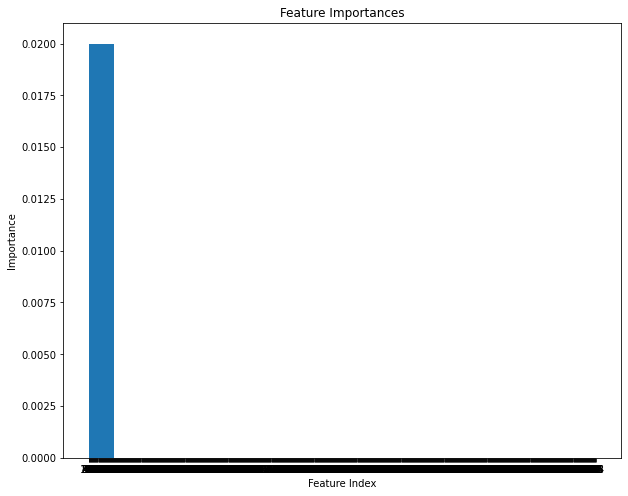

In [10]:
# Get feature importances
importances = ada_clf.feature_importances_

# Plot
plt.figure(figsize=(10, 8))
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

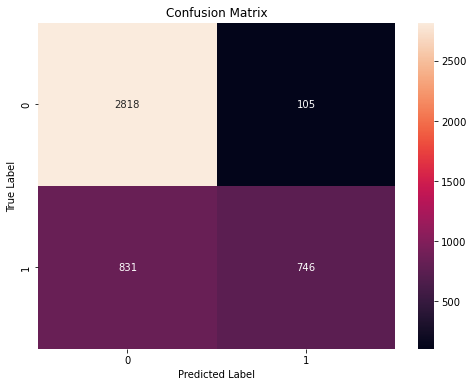

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

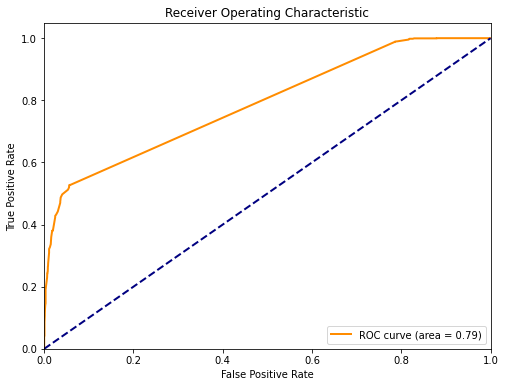

In [13]:
from sklearn.metrics import roc_curve, auc

# Specify pos_label as 2 (treating class 2 as the positive class)
fpr, tpr, thresholds = roc_curve(y_test, ada_clf.decision_function(X_test), pos_label=2)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()